# Problem Statement:

### To explore classical time series modeling on time series data (4.	https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [35]:
df_comed = pd.read_csv("resources/COMED_hourly.csv")

In [36]:
df_comed = df_comed.sort_values(by='Datetime').reset_index().drop(columns=['index'])

In [37]:
df_comed.dtypes

Datetime     object
COMED_MW    float64
dtype: object

In [38]:
df_comed['Datetime'] = pd.to_datetime(df_comed['Datetime'])

In [39]:
df_comed.dtypes

Datetime    datetime64[ns]
COMED_MW           float64
dtype: object

In [40]:
df_comed.head()

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0


In [41]:
df_comed.shape

(66497, 2)

In [42]:
df_comed = df_comed.drop_duplicates()

In [43]:
df_comed.shape

(66497, 2)

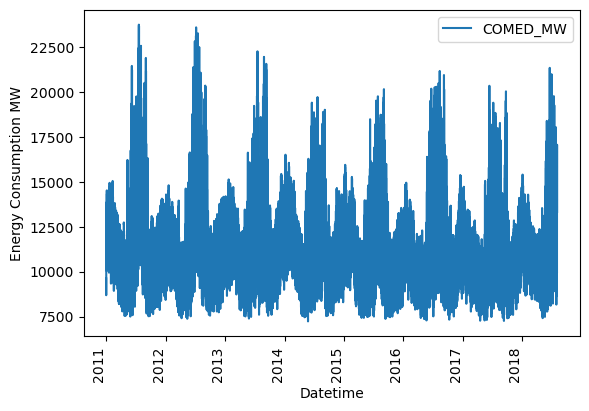

In [44]:
df_comed.plot(x='Datetime', y='COMED_MW')
plt.xticks(rotation=90)
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption MW')
plt.show()

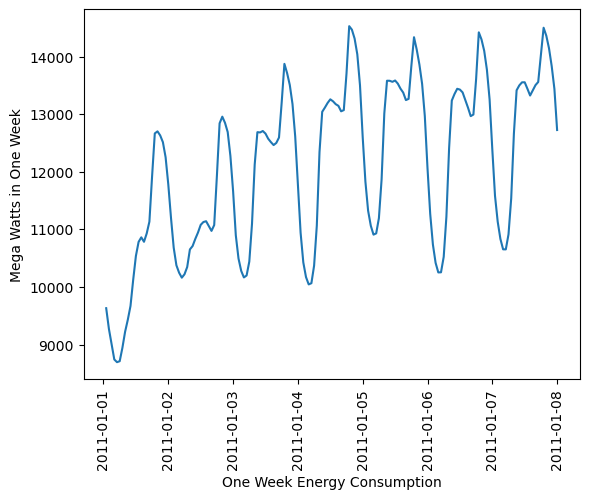

In [45]:
plt.plot(df_comed.Datetime[:(7*24)], df_comed['COMED_MW'][:(7*24)])
plt.xticks(rotation = 90)
plt.xlabel('One Week Energy Consumption')
plt.ylabel('Mega Watts in One Week')
plt.show()

In [46]:
# Creating some extra features.
def create_features(df):
    df['Date'] = df['Datetime']
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df.drop('Date', axis=1, inplace=True)
    return df

df_comed = create_features(df_comed)

C:\Users\ma6114132\AppData\Local\Temp\ipykernel_5472\3141569287.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df['Date'].dt.weekofyear


In [47]:
df_comed.head()

,Datetime,COMED_MW,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
0,2011-01-01 01:00:00,9631.0,1,5,1,1,2011,1,1,52,1.041667
1,2011-01-01 02:00:00,9273.0,2,5,1,1,2011,1,1,52,1.083333
2,2011-01-01 03:00:00,9011.0,3,5,1,1,2011,1,1,52,1.125000
3,2011-01-01 04:00:00,8741.0,4,5,1,1,2011,1,1,52,1.166667
4,2011-01-01 05:00:00,8694.0,5,5,1,1,2011,1,1,52,1.208333


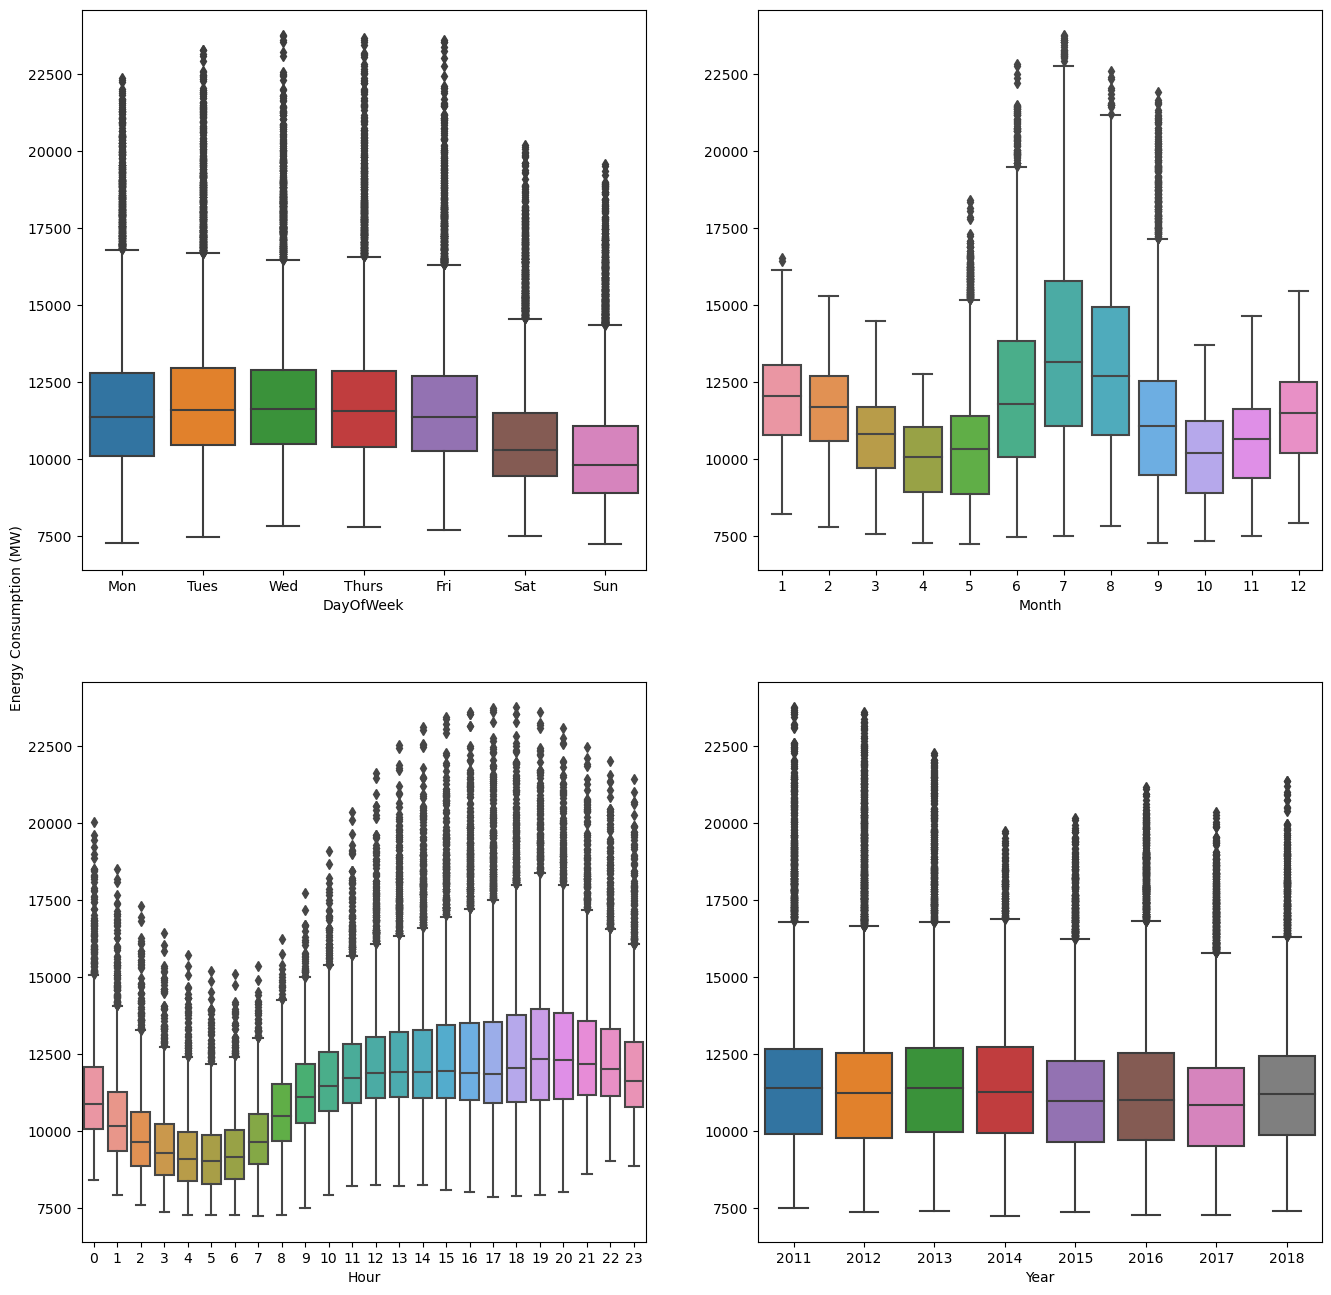

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=df_comed.DayOfWeek, y=df_comed.COMED_MW, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=df_comed.Month, y=df_comed.COMED_MW, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=df_comed.Hour, y=df_comed.COMED_MW, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=df_comed.Year, y=df_comed.COMED_MW, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.savefig('boxplots.png')
plt.show()

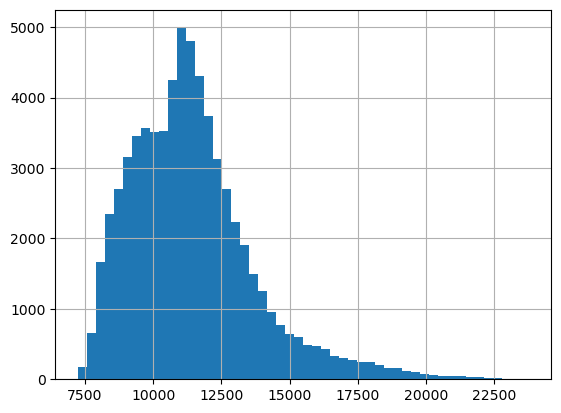

In [49]:
data_series = df_comed['COMED_MW']
data_series.hist(bins=50)
plt.savefig('histogram.png')
plt.show()

Now let's plot the seasonal plot per year

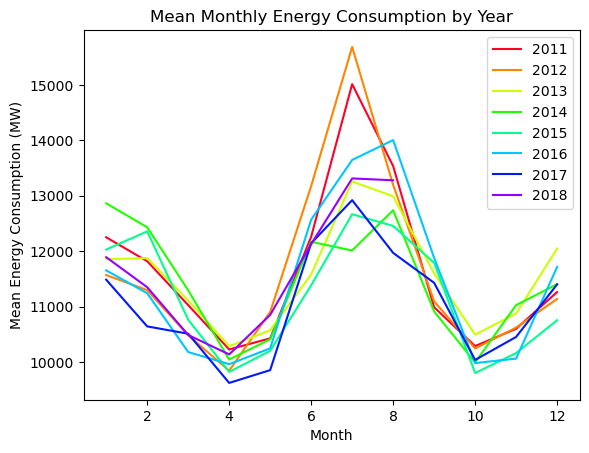

In [50]:
year_group = df_comed.groupby(['Year', 'Month']).mean().reset_index()
years = df_comed['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
# print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df = year_group[year_group['Year'] == y]
    #rolling_mean = df.DUQ_MW.rolling(window=7*24).mean()
    plt.plot(df['Month'], df['COMED_MW'])
plt.title('Mean Monthly Energy Consumption by Year')
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(df_comed.Year.unique())
plt.savefig('seasonal_plot.png')
plt.show()

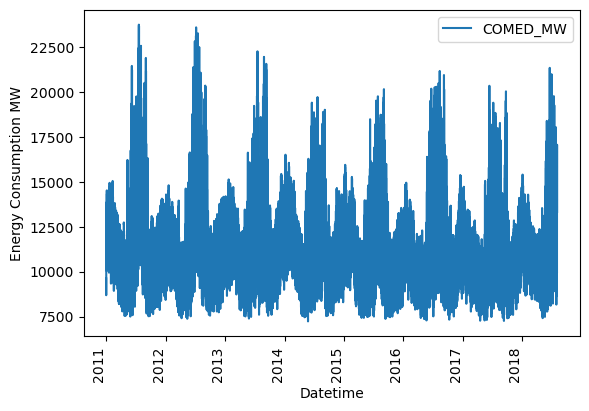

In [54]:
df_comed.plot(x='Datetime', y='COMED_MW')
plt.xticks(rotation=90)
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption MW')
plt.show()

Seasonal Decomposition. We can see that the daily amplitude also follows a seasonal pattern, increasing or decreasing depending on the day of the year. In an additive model, we would expect the amplitude to remain relatively constant. Since the amplitude changes over time, we will assume that a multiplicative model best applies to the data.

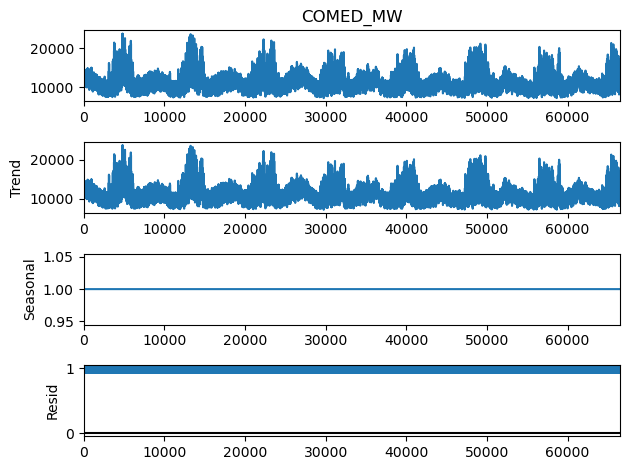

In [59]:
mult_decompose = seasonal_decompose(df_comed['COMED_MW'], period=1, model='multiplicative')
mult_decompose.plot()
plt.show()

In [7]:
# Getting the length and taking the samle of the data to 
# calculate the mean and variance of sample data (This is the first way to check for stationarity)

time_series_len = df_comed.shape[0]
sample_legth = time_series_len // 3
part_1, part_2, part_3 = df_comed['COMED_MW'][0:sample_legth], df_comed['COMED_MW'][(sample_legth):(2*sample_legth)], df_comed['COMED_MW'][(2*sample_legth):(3*sample_legth)]
print("the mean of samples are ", part_1.mean(), part_2.mean(), part_3.mean())
print("the variance of samples are ",part_1.var(), part_2.var(), part_3.var())

the mean of samples are  11690.207759981953 11288.859553349876 11281.239612000902
the variance of samples are  6572132.688425587 4017743.361206887 5228535.912940826


Looks like the data is not stationary. Let's apply ADF test.

In [60]:
# ADF Test
result = adfuller(df_comed['COMED_MW'], autolag='AIC')

In [61]:
# 1. ADF Test Statistic
# 2. p-value
# 3. lags
result

(-14.831166977457908,
 1.89830079869459e-27,
 61,
 66435,
 {'1%': -3.430448435353142,
  '5%': -2.861583506641688,
  '10%': -2.5667931571051694},
 829654.0349328336)

p-value is greater than 5% (-2.86158). Therefore null hypothesis cannot be rejected (i.e. data is non stationary)

In [17]:
x=df_comed['COMED_MW']
x[0]

9970.0

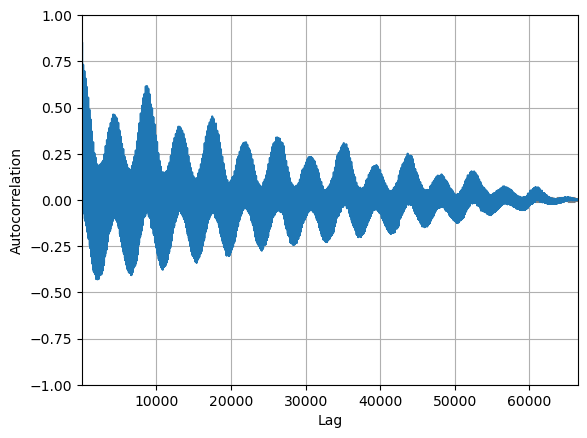

In [62]:
autocorrelation_plot(df_comed['COMED_MW'])
plt.show()

## Conclusion:

The current time series is not stationary. In order to apply ARIMA model we have to make it stationary. For this apply log and take the difference. If the data becomes stationary then ARIMA can be applied. If it is not statinary then ARIMA may not be the correct model.
Next, for the ARIMA model the first step is to identify the order (p, d, q) where 'p' is the AR, 'q' is the differencing part, 'r' is the MA part.
1) Now in order to find out 'p' we need to look at the PACF graph which is in turn dependent on ACF.
2) In order to find 'q' we can use the ACF plot, for instance for the above ACF plot the MA does not have any impact. i.e. q=0
3) 'd' is the differencing part to make the data stationary.